In [ ]:
# probably cannot run, added too many stuff

In [23]:
# sigma_align = 0.08
# sigma_cross = 0.5
# sigma_close = 20

sigma_align = 0.08
sigma_cross = 0.5
sigma_close = 25

In [24]:
import numpy as np
import pandas as pd
from pathlib import Path
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print = display
pd.options.display.float_format = '{:.2f}'. format

In [25]:
dp = Path('dataset/fulldata')
lp = Path('dataset/labels')

d = set(map(lambda x: x.name, dp.glob('*.csv')))
l = set(map(lambda x: x.name, lp.glob('*.csv')))

pairs = sorted(map(lambda x: (dp/x, lp/x), set.intersection(d, l)))

In [26]:
def rad(deg):
    return deg / 180 * np.pi


def add(rad, delta):
    '''Adds an angle to a radian angle and keep it in [-pi,pi)'''
    return (rad+delta+np.pi) % (2*np.pi) - np.pi


def to_xy(r, theta):
    normal_reference_theta = add(theta, np.pi/2)
    return r * np.cos(normal_reference_theta), r * np.sin(normal_reference_theta)


def to_rtheta(x, y):
    return np.sqrt(x**2 + y**2), add(np.arctan2(y,x), -np.pi/2)


# actually has no use as everything went to normal dist
def sign_of(*feats):
    return np.all([feat > 0 for feat in feats], axis=0) * 2 - 1


In [27]:
def how_aligned(theta1, theta2, sigma=sigma_align):
    '''Measures how close two angles are with N(0, sigma)'''
    dist = theta1 - theta2
    sigma_sq = sigma*sigma
    norm = lambda x:np.exp(-x**2/(2*sigma_sq))/np.sqrt(2*np.pi*sigma_sq)
    return norm(dist) / norm(0)
    
    # '''Gives a [-1,1] measure of how aligned two angles are'''
    # return np.cos(add(theta1,-theta2))**11



def how_crossed(theta1, theta2, sigma=sigma_cross):
    '''Measures how perpendicular two angles are with N(0, sigma)'''
    dist = np.pi/2 - abs(theta1-theta2)
    sigma_sq = sigma*sigma
    norm = lambda x:np.exp(-x**2/(2*sigma_sq))/np.sqrt(2*np.pi*sigma_sq)
    return norm(dist) / norm(0)
    
    # '''Gives a [0,1] mesaure of how perpendicular two angles are'''
    # return abs(np.sin(add(theta1,-theta2)))


def how_close(dist, sigma=sigma_close):
    '''Gives a measure of how close a distance is with N(0, sigma)'''
    sigma_sq = sigma*sigma
    norm = lambda x:np.exp(-x**2/(2*sigma_sq))/np.sqrt(2*np.pi*sigma_sq)
    return norm(dist) / norm(0)


def calc_lead_tendency(agent, self):
    distance = how_close(agent['r'])
    yaw_alignment = how_aligned(0, agent['yaw'])
    chasing_now = how_aligned(self['v_theta'], agent['theta'])
    ahead = how_aligned(0, agent['theta'])
    chasing = yaw_alignment + chasing_now + ahead

    # sign = np.all([sign_of(chasing, ahead), agent['type'] == 'Vehicle'], axis=0)
    is_vehicle = agent['type'] == 'Vehicle'
    return distance * chasing * is_vehicle


def calc_cross_tendency(agent, self):
    distance = how_close(agent['r'])
    yaw_cross = how_crossed(0, agent['yaw'])
    velocity_cross = how_crossed(self['v_theta'], agent['v_theta'])
    crossing = how_crossed(0, agent['v_theta'])
    x_velocity_degree = 1 - how_close(agent['v_x'])
    cross = velocity_cross * yaw_cross * crossing * x_velocity_degree
    # ahead = how_aligned(0, agent['theta'])

    return distance * cross


def calc_align_tendency(agent, self):
    distance = how_close(agent['r'])
    align_yaw = how_aligned(0, agent['yaw'])
    align_velocity = how_aligned(self['v_theta'], agent['v_theta'])
    
    return distance * align_yaw * align_velocity


def calc_follow_turn_tendency(agent, self):
    distance = how_close(agent['r'])
    follow_turn = self['d_yaw'] * (agent['yaw']-0)
    follow_d_turn = self['dd_yaw'] * (agent['d_yaw']-self['d_yaw'])

    sign = sign_of(follow_turn, follow_d_turn, agent['type'] == 'Vehicle')
    return distance * abs(follow_turn * follow_d_turn) * sign

In [28]:
def get_agents(data):
    agents = pd.DataFrame()

    # self
    self = data.iloc[0]
    self_yaw_rad = rad(self['YAW'])
    assert self['TRACK_ID'] == 'ego'

    # agents type
    agents['type'] = data['OBJECT_TYPE']
    agents['track_id'] = data['TRACK_ID']

    # agents yaw
    agents['yaw'] = add(rad(data['YAW']), -self_yaw_rad)
    agents['d_yaw'] = rad(data['DYAW'])
    agents['dd_yaw'] = rad(data['DDYAW'])

    # agents position
    agents['r'], agents['theta'] = to_rtheta(data['X']-self['X'], data['Y']-self['Y'])
    agents['theta'] = add(agents['theta'], -self_yaw_rad)
    agents['x'], agents['y'] = to_xy(agents['r'], agents['theta'])

    # agents velocity
    agents['v_r'], agents['v_theta'] = to_rtheta(data['V_X'], data['V_Y'])
    agents['v_theta'] = add(agents['v_theta'], -self_yaw_rad)
    agents['v_x'], agents['v_y'] = to_xy(agents['v_r'], agents['v_theta'])

    # agents acceleration
    agents['a_r'], agents['a_theta'] = to_rtheta(data['A_X'], data['A_Y'])
    agents['a_theta'] = add(agents['a_theta'], -self_yaw_rad)
    agents['a_x'], agents['a_y'] = to_xy(agents['a_r'], agents['a_theta'])

    # update self
    self = agents.iloc[0].copy()
    self.drop(labels=['type','track_id','x','y','r','theta','yaw'], inplace=True)

    # agents lead tendency
    agents['lead_tendency'] = calc_lead_tendency(agents, self)

    # agents cross tendency
    agents['cross_tendency'] = calc_cross_tendency(agents, self)

    # agents align tendency
    agents['align_tendency'] = calc_align_tendency(agents, self)

    # agents follow turn tendency
    agents['follow_turn_tendency'] = calc_follow_turn_tendency(agents, self)

    return self, agents[1:]

In [29]:
# test a specific timeframe and its labels 

CONSIDERED_LABELS = [
    "1.1.1 LeadVehicleConstant",
    "1.1.2 LeadVehicleCutOut",
    "1.1.3 VehicleCutInAhead",
    "1.1.4 LeadVehicleDecelerating",
    "1.1.5 LeadVehicleStppoed",
    "1.1.6 LeadVehicleAccelerating",
    "1.1.7  LeadVehicleWrongDriveway",
    "2.1.4 LeadVehicleStppoed",     # stop and wait
    "2.1.5 PedestrianCrossing",
    "2.4.1 NoVehiclesAhead",        # go straight
    "2.4.2 WithLeadVehicle",
    "2.4.3 VehiclesCrossing",
    "2.5.1 NoVehiclesAhead",        # turn left
    "2.5.2 WithLeadVehicle",
    "2.5.3 VehiclesCrossing",
    "2.6.1 NoVehiclesAhead",        # turn right
    "2.6.2 WithLeadVehicle",
    "2.6.3 VehiclesCrossing",
    "2.7.1 NoVehiclesAhead",        # uturn
]

def t(i, j):
    # get stuff
    timestamp, data = list(pd.read_csv(pairs[i][0]).groupby('TIMESTAMP'))[j]
    label = pd.read_csv(pairs[i][1]).iloc[j]
    filename = pairs[i][0].name
    if label['third_class'] not in CONSIDERED_LABELS:
        return None, None, None, label, filename

    # transform
    data = data.reset_index(drop=True)
    self, agents = get_agents(data)
    return self, agents, label, data, filename

In [30]:
# "there is a lead vehicle": lead vehicle1 exists and it has a reasonable lead tendency
# - implying that this car is almost directly infront of the current car and going the same direction as the current car

# "there is a cross vehicle": cross vehicle1 exists and it has a reasonable cross tendency
# - implying that either
#   - this car is infront of the current car and somewhat crossing with the current car
#   - or this car is not infront of the current car whatsoever but is crossing the current car very well


["1.1.1 LeadVehicleConstant",   # there is a lead vehicle, and its a_r is near zero
"1.1.2 LeadVehicleCutOut",      # there is a cross agent whose x is small but vx and ax are big
"1.1.3 VehicleCutInAhead",      # there is a cross agent whose x is larger yet vx and ax are pointing opposite it
"1.1.4 LeadVehicleDecelerating",    # there is a lead vehicle, and its a_r is negative
"1.1.5 LeadVehicleStppoed",         # there is a lead vehicle, and its v_r is small
"1.1.6 LeadVehicleAccelerating",    # there is a lead vehicle, and its a_r is positive
"1.1.7  LeadVehicleWrongDriveway",  # I don't know what's that...
"2.1.4 LeadVehicleStppoed",     # there is a lead vehicle, and its a_r is near zero
"2.1.5 PedestrianCrossing",     # there is a cross agent whose type is Pedestrian
"2.4.1 NoVehiclesAhead",        # there is no leading vehicle
"2.4.2 WithLeadVehicle",        # there is a leading vehicle
"2.4.3 VehiclesCrossing",       # there is a cross agent whose cross factor is big
"2.5.1 NoVehiclesAhead",        # there is no following_turn vehicle
"2.5.2 WithLeadVehicle",        # there is a following_turn vehicle
"2.5.3 VehiclesCrossing",       # there is a cross agent whose cross factor is big
"2.6.1 NoVehiclesAhead",        # there is no following_turn vehicle
"2.6.2 WithLeadVehicle",        # there is a following_turn vehicle
"2.6.3 VehiclesCrossing",       # there is a cross agent whose cross factor is big
"2.7.1 NoVehiclesAhead",]       
df_backup = df.copy()

a = df[df['label'] == '1.1.1 LeadVehicleConstant']
a = a.iloc[0]
a


df['secondclass']

KeyError: 'secondclass'

In [31]:


s,a,l,d,f = t(321,12)

l

# calc_lead_tendency()

KeyError: 'X'

In [32]:
sa = a.sort_values(by='lead_tendency', ascending=False)
q = sa.iloc[0]
distance = how_close(q['r'])
chasing_now = how_aligned(s['v_theta'], q['theta']) + how_close(q['x'], sigma=distance)
chasing_turn = how_aligned(s['d_yaw'], q['yaw'])
chasing_dturn = how_aligned(s['dd_yaw']+s['d_yaw'], q['d_yaw'])
chasing = chasing_now + chasing_turn + chasing_dturn
ahead = how_aligned(0, q['theta'])

TypeError: Series.sort_values() got an unexpected keyword argument 'by'

In [50]:
def tr():
    N_AGENTS = 3
    N_FILES = 100000
    SKIP = 0

    # data list and label list
    dl = []
    ll = []

    for pair in tqdm.tqdm(pairs):
        if SKIP > 0:
            SKIP -= 1
            continue

        dl += map(lambda x:x[1], list(pd.read_csv(pair[0]).groupby('TIMESTAMP')))
        label_df = pd.read_csv(pair[1])
        label_df['filename'] = pair[1].name
        ll.append(label_df)

        N_FILES -= 1
        if N_FILES == 0:
            break

    ldf = pd.concat(ll, ignore_index=True)

    rows = []

    for i in tqdm.tqdm(range(len(dl))):
        di = dl[i]
        li = ldf.iloc[i]
        self,agents = get_agents(di)
        if (len(agents) == 0):
            continue
        agents.drop(columns=['track_id'], inplace=True)
        f = F(li['third_class'])
        if f is None:
            continue
        agents['important'] = f(agents)

        leadings = agents.sort_values(by='lead_tendency', ascending=False)[:N_AGENTS]
        crossings = agents.sort_values(by='cross_tendency', ascending=False)[:N_AGENTS]
        alignings = agents.sort_values(by='align_tendency', ascending=False)[:N_AGENTS]
        following_turn = agents.sort_values(by='follow_turn_tendency', ascending=False)[:N_AGENTS]

        self_row = self.rename(lambda x: f'{x}_self')

        leading_row= pd.concat([e.rename(lambda x: f'{x}_leading_{i}') for i, e in enumerate(leadings.iloc)])
        crossing_row = pd.concat([e.rename(lambda x: f'{x}_crossing_{i}') for i, e in enumerate(crossings.iloc)])
        aligning_row = pd.concat([e.rename(lambda x: f'{x}_aligning_{i}') for i, e in enumerate(alignings.iloc)])
        following_turn_row = pd.concat([e.rename(lambda x: f'{x}_following_turn_{i}') for i, e in enumerate(following_turn.iloc)])
        label_row = li.rename({'first_class': 'first_class', 'second_class': 'second_class', 'third_class': 'label', 'filename': 'filename'})

        row = pd.concat([self_row, leading_row, crossing_row, aligning_row, following_turn_row, label_row])
        rows.append(row)

    df = pd.DataFrame(rows)
    # return type(df)

    cats = ['first_class', 'second_class']
    for cat in ['leading', 'crossing', 'aligning', 'following_turn']:
        for i in range(N_AGENTS):
            cats.append(f'type_{cat}_{i}')
    df = pd.get_dummies(df, columns=cats)

    df = df[~df.isna().any(axis=1)]

    df = df[df['label'].isin(CONSIDERED_LABELS)]

    df.reset_index(drop=True, inplace=True)

    df.to_csv('examples/newlycleaned.csv', index=False)

    return df
    # return df


def trsp():
    return pd.read_csv('examples/newlycleaned.csv')

df = tr()

100%|██████████| 27080/27080 [02:57<00:00, 152.71it/s]


In [40]:
dffl = list(df.groupby('filename'))
df['label']

0       1.1.2 LeadVehicleCutOut
1       1.1.2 LeadVehicleCutOut
2       1.1.2 LeadVehicleCutOut
3       1.1.2 LeadVehicleCutOut
4       1.1.2 LeadVehicleCutOut
                 ...           
8177    1.1.3 VehicleCutInAhead
8178    1.1.3 VehicleCutInAhead
8179    1.1.2 LeadVehicleCutOut
8180    1.1.2 LeadVehicleCutOut
8181    1.1.2 LeadVehicleCutOut
Name: label, Length: 8182, dtype: object

In [51]:
def train_test_split_by_files(df, random_state=None, test_size=0.2):
    files = list(df.groupby('filename'))
    f_train, f_test = train_test_split(files, test_size=test_size, random_state=random_state)
    train, test = pd.concat([f[1] for f in f_train], axis=0, ignore_index=True), pd.concat([f[1] for f in f_test], axis=0, ignore_index=True)
    X_train, X_test, y_train, y_test = train.drop(columns=['label', 'filename']), test.drop(columns=['label', 'filename']), train['label'], test['label']
    return X_train, X_test, y_train, y_test

In [52]:
MAX_DEPTH = 13
TEST_SIZE = 0.2
RANDOM_STATE = 42

X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split_by_files(df, test_size=0.2, random_state=RANDOM_STATE)
y_train_encoded = pd.Series([CONSIDERED_LABELS.index(y) for y in y_train])
y_test_encoded = pd.Series([CONSIDERED_LABELS.index(y) for y in y_test])

clf = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=RANDOM_STATE)
clf.fit(X_train, y_train_encoded)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test_encoded, y_pred)
mat = confusion_matrix(y_test_encoded, y_pred)
report = classification_report(y_test_encoded, y_pred, zero_division=0)

print(acc)

0.5722188076213891

0        True
1        True
2        True
3        True
4        True
        ...  
6550    False
6551    False
6552    False
6553    False
6554    False
Name: important_aligning_2, Length: 6555, dtype: object

KeyError: 'important'

In [62]:
TEST_SIZE = 0.2
RANDOM_STATE = 42

X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split_by_files(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)
y_train_encoded = pd.Series([CONSIDERED_LABELS.index(y) for y in y_train])
y_test_encoded = pd.Series([CONSIDERED_LABELS.index(y) for y in y_test])

# clf = RandomForestClassifier(random_state=RANDOM_STATE)
clf = XGBClassifier(random_state=RANDOM_STATE)
clf.fit(X_train, y_train_encoded)


y_pred = clf.predict(X_test)
acc = accuracy_score(y_test_encoded, y_pred)
mat = confusion_matrix(y_test_encoded, y_pred)
report = classification_report(y_test_encoded, y_pred, zero_division=0)

print(acc)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:important_leading_2: object, important_crossing_2: object, important_aligning_2: object, important_following_turn_2: object

In [20]:
X_train.columns

Index(['d_yaw_self', 'dd_yaw_self', 'v_r_self', 'v_theta_self', 'v_x_self',
       'v_y_self', 'a_r_self', 'a_theta_self', 'a_x_self', 'a_y_self',
       ...
       'type_following_turn_0_Pedestrian', 'type_following_turn_0_Vehicle',
       'type_following_turn_1_Barrier', 'type_following_turn_1_Bicycle',
       'type_following_turn_1_Pedestrian', 'type_following_turn_1_Vehicle',
       'type_following_turn_2_Barrier', 'type_following_turn_2_Bicycle',
       'type_following_turn_2_Pedestrian', 'type_following_turn_2_Vehicle'],
      dtype='object', length=310)

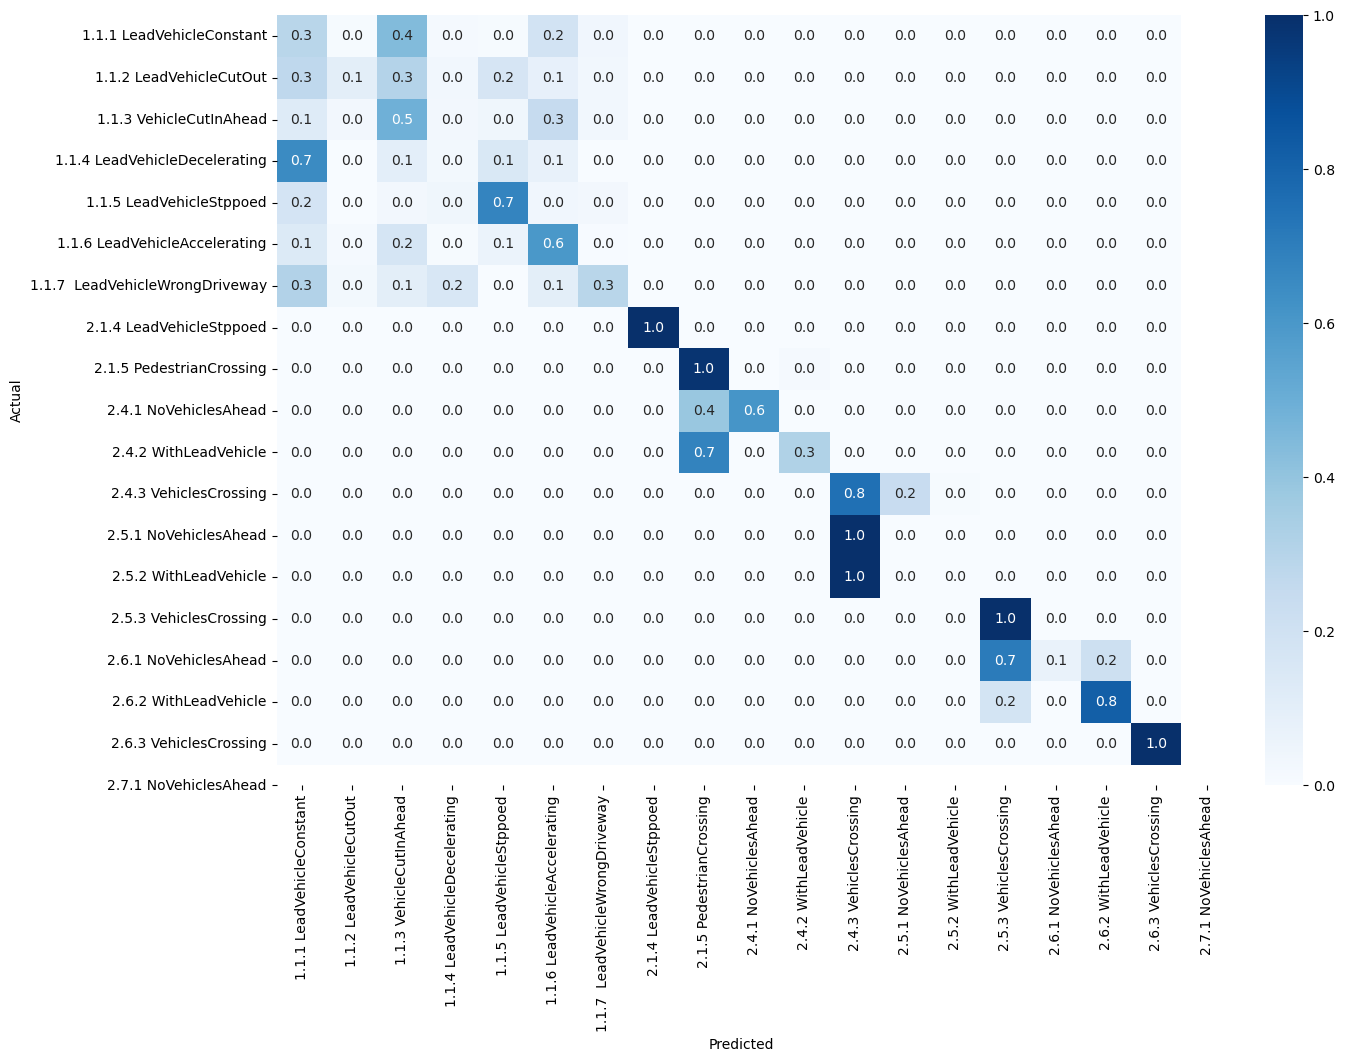

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

normalized_mat = mat.astype(float) / mat.sum(axis=1)[:, np.newaxis]
# normalized_mat = mat
plt.figure(figsize=(15,10))
sns.heatmap(pd.DataFrame(normalized_mat), annot=True, fmt='.1f', cmap='Blues', xticklabels=CONSIDERED_LABELS, yticklabels=CONSIDERED_LABELS)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.savefig('conf.png')

In [1394]:
import dtreeviz
# os.environ['PATH'] += os.pathsep + 

# y_train_str = [CONSIDERED_LABELS[i] for i in y_train_encoded]
# y_train_str_unique = list(set(y_train_str))
# y_train_newly_encoded = pd.Series([y_train_str_unique.index(y) for y in y_train])

viz_model = dtreeviz.model(clf,
                           X_train=X_train,
                           y_train=y_train_encoded,
                           feature_names=X_train.columns.tolist(),
                           class_names=CONSIDERED_LABELS,
                          )
                          

v = viz_model.view()
v.save('dtreeviz.svg')

/opt/miniconda3/envs/crat/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


In [48]:

def vand(*conds):
    return np.all(conds, axis=0)

def vor(*conds):
    return np.any(conds, axis=0)

def F(label):
    '''
    Be loose.
    you can include everything you pick into consideration, but if you miss, you will not have anything to reference to.
    Worst case is lambda agent: True, where you just include every car...
    '''

    def is_lead_vehicle(agent):
        return vand(
            abs(agent['x']) < 3.5,
            agent['y'] > 0, 
            abs(agent['yaw']) < np.pi/4
        )

    # def is_cutout_vehicle(agent):
    #     pass

    def is_cutin_vehicle(agent):
        return vand(
            vor(
                vand(agent['yaw'] > 0.02, agent['v_x'] < -0.1, 4 > agent['x'], agent['x'] > 0.5),
                vand(agent['yaw'] < -0.02, agent['v_x'] > 0.1, -4 < agent['x'], agent['x'] < -0.5)
            ),
            agent['y'] > 0, agent['v_x'] * agent['x'] < 0,
        )

    def is_crossing_pedestrian(agent):
        return vand(
            agent['type'].isin(['Pedestrian', 'Bicycle']),
            abs(abs(agent['yaw'])-np.pi/2) < np.pi/4,
            agent['y'] > 0,
            abs(agent['x']) < 5,
        )
    
    def is_leading_wrong_driveway_vehicle(agent):
        return vand(
            abs(agent['x']) < 4,
            agent['y'] > 10,
            abs(agent['yaw']) > np.pi/2,
            agent['v_y'] < 0,
        )

    def is_crossing_vehicle(agent):
        return vand(
            abs(abs(agent['yaw'])-np.pi/2) < np.pi/3,
            abs(agent['x']) < 7,
            agent['y'] > 0,
            agent['type'] != 'Pedestrian'
        )

    def is_lead_vehicle_turning_left(agent):
        return vand(
            agent['yaw'] < np.pi/3,
            agent['yaw'] > 0,
            agent['x'] < 0,
            agent['x'] > -9,
            agent['y'] > 0,
            agent['type'] != 'Pedestrian'
        )

    def is_cross_vehicle_while_turnleft(agent):
        return vand(
            abs(abs(agent['yaw'])-np.pi/2) < np.pi/3,
            abs(agent['x']) < 7,
            agent['y'] > 0,
            agent['type'] != 'Pedestrian'
        )

    def is_lead_vehicle_turning_right(agent):
        return vand(
            agent['yaw'] > -np.pi/2,
            agent['yaw'] < 0,
            agent['x'] > 0,
            agent['x'] < 9,
            agent['y'] > 0,
            agent['type'] != 'Pedestrian'
        )

    def is_cross_vehicle_while_turnright(agent):
        return vand(
            abs(abs(agent['yaw'])-np.pi/2) < np.pi/3,
            abs(agent['x']) < 7,
            agent['y'] > 0,
            agent['type'] != 'Pedestrian'
        )

    _F = {
        '1.1.1 LeadVehicleConstant': is_lead_vehicle,
        # '1.1.2 LeadVehicleCutOut': is_cutout_vehicle,
        '1.1.2 LeadVehicleCutOut': is_lead_vehicle,
        '1.1.3 VehicleCutInAhead': is_cutin_vehicle,
        '1.1.4 LeadVehicleDecelerating': is_lead_vehicle,
        '1.1.5 LeadVehicleStppoed': is_lead_vehicle,
        '1.1.6 LeadVehicleAccelerating': is_lead_vehicle,
        '1.1.7  LeadVehicleWrongDriveway': is_leading_wrong_driveway_vehicle,
        '2.1.4 LeadVehicleStppoed': is_lead_vehicle,                    # cross & stop and wait
        '2.1.5 PedestrianCrossing': is_crossing_pedestrian,
        '2.4.1 NoVehiclesAhead': lambda _: False,                       # cross & go straight
        '2.4.2 WithLeadVehicle': is_lead_vehicle,
        '2.4.3 VehiclesCrossing': is_crossing_vehicle,
        '2.5.1 NoVehiclesAhead': lambda _: False,                       # cross & turn left
        '2.5.2 WithLeadVehicle': is_lead_vehicle_turning_left,
        '2.5.3 VehiclesCrossing': is_cross_vehicle_while_turnleft,
        '2.6.1 NoVehiclesAhead': lambda _: False,                       # cross & turn right
        '2.6.2 WithLeadVehicle': is_lead_vehicle_turning_right,
        '2.6.3 VehiclesCrossing': is_cross_vehicle_while_turnright,
        '2.7.1 NoVehiclesAhead': lambda _: False,           # cross & uturn
    }

    if label in _F:
        return _F[label]
    return None

In [47]:
for i in list(X_train.columns):
    if 'type' in i:
        print(i)

'type_leading_0_Bicycle'

'type_leading_0_Pedestrian'

'type_leading_0_Vehicle'

'type_leading_1_Barrier'

'type_leading_1_Bicycle'

'type_leading_1_Pedestrian'

'type_leading_1_Vehicle'

'type_leading_2_Barrier'

'type_leading_2_Bicycle'

'type_leading_2_Pedestrian'

'type_leading_2_Vehicle'

'type_crossing_0_Barrier'

'type_crossing_0_Bicycle'

'type_crossing_0_Pedestrian'

'type_crossing_0_Vehicle'

'type_crossing_1_Barrier'

'type_crossing_1_Bicycle'

'type_crossing_1_Pedestrian'

'type_crossing_1_Vehicle'

'type_crossing_2_Barrier'

'type_crossing_2_Bicycle'

'type_crossing_2_Pedestrian'

'type_crossing_2_Vehicle'

'type_aligning_0_Barrier'

'type_aligning_0_Bicycle'

'type_aligning_0_Pedestrian'

'type_aligning_0_Vehicle'

'type_aligning_1_Barrier'

'type_aligning_1_Bicycle'

'type_aligning_1_Pedestrian'

'type_aligning_1_Vehicle'

'type_aligning_2_Barrier'

'type_aligning_2_Bicycle'

'type_aligning_2_Pedestrian'

'type_aligning_2_Vehicle'

'type_following_turn_0_Barrier'

'type_following_turn_0_Bicycle'

'type_following_turn_0_Pedestrian'

'type_following_turn_0_Vehicle'

'type_following_turn_1_Barrier'

'type_following_turn_1_Bicycle'

'type_following_turn_1_Pedestrian'

'type_following_turn_1_Vehicle'

'type_following_turn_2_Barrier'

'type_following_turn_2_Bicycle'

'type_following_turn_2_Pedestrian'

'type_following_turn_2_Vehicle'